In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
%matplotlib inline
sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['product_id'] = buy_sessions['product_id'].astype(str)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
df = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
df['product_id'] = df['product_id'].astype(str)


In [2]:
df['date'] = pd.to_datetime(df['date'])

In [3]:
df=df.groupby(by=[pd.Grouper(key='date', freq='W'), pd.Grouper(key='product_id')]).sum()

In [4]:
products = pd.read_json("../data/raw/second/products.jsonl", lines=True)
del products['product_name']
products['product_id']=products['product_id'].astype(str)
products.index=products['product_id']
df=df.join(products,on='product_id')

In [5]:
df.index = df.index.get_level_values(0)

In [6]:
df

,amount,product_id,category_path,price
date,,,,
2019-08-04,3,1002,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2019-08-04,0,1003,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
2019-08-04,0,1004,Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2019-08-04,0,1005,Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2019-08-04,1,1006,Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
...,...,...,...,...
2021-12-26,0,1310,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,79.99
2021-12-26,0,1311,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,189.99
2021-12-26,0,1312,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,99.90


In [7]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index.get_level_values(0)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.weekofyear
    del df['date']
    df=pd.get_dummies(df,columns=['category_path'])
    return df

In [8]:
split_date = pd.to_datetime('2021-09-01')
copy=df.copy()
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [9]:
train=create_features(train)
test=create_features(test)
test

C:\Users\micha\AppData\Local\Temp/ipykernel_15244/583452908.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


,amount,product_id,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV
date,,,,,,,,,,,,,
2021-09-05,0,1002,2048.50,3,9,2021,35,0,0,0,1,0,0
2021-09-05,0,1003,7639.00,3,9,2021,35,0,0,0,1,0,0
2021-09-05,0,1004,49.99,3,9,2021,35,0,0,1,0,0,0
2021-09-05,0,1005,49.99,3,9,2021,35,0,0,1,0,0,0
2021-09-05,0,1006,59.90,3,9,2021,35,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,0,1310,79.99,4,12,2021,51,0,0,0,0,0,1
2021-12-26,0,1311,189.99,4,12,2021,51,0,0,0,0,0,1
2021-12-26,0,1312,99.90,4,12,2021,51,0,0,0,0,0,1


In [10]:
train['monthly_avg'] = train.groupby(['product_id','month'])['amount'].transform('mean')
train['weekly_avg'] = train.groupby(['product_id','weekofyear'])['amount'].transform('mean')

monthly_avg = train.groupby(['product_id','month'])['amount'].mean().reset_index()
weekly_avg = train.groupby(['product_id','weekofyear'])['amount'].mean().reset_index()

In [11]:
print(len(train),len(test))

21473 3349


In [12]:
test

,amount,product_id,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV
date,,,,,,,,,,,,,
2021-09-05,0,1002,2048.50,3,9,2021,35,0,0,0,1,0,0
2021-09-05,0,1003,7639.00,3,9,2021,35,0,0,0,1,0,0
2021-09-05,0,1004,49.99,3,9,2021,35,0,0,1,0,0,0
2021-09-05,0,1005,49.99,3,9,2021,35,0,0,1,0,0,0
2021-09-05,0,1006,59.90,3,9,2021,35,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,0,1310,79.99,4,12,2021,51,0,0,0,0,0,1
2021-12-26,0,1311,189.99,4,12,2021,51,0,0,0,0,0,1
2021-12-26,0,1312,99.90,4,12,2021,51,0,0,0,0,0,1


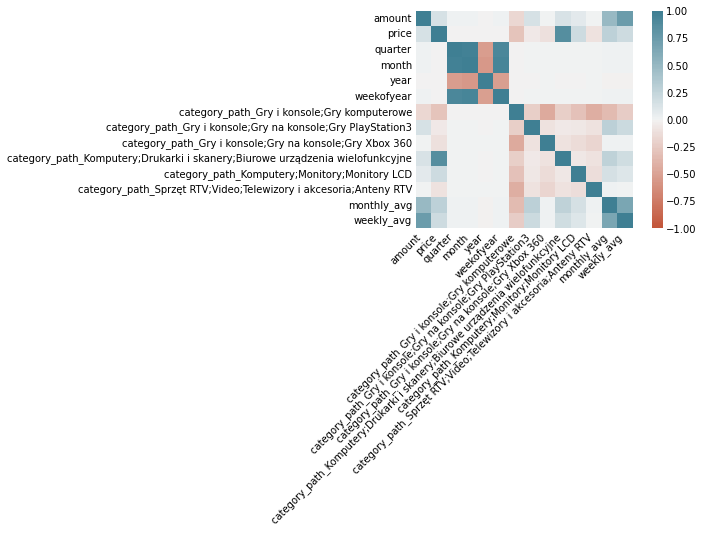

In [27]:
import seaborn as sns
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [13]:
def merge(df1, df2, col,col_name):
    
    df1 =pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col, right_index=False, sort=True,
             copy=True, indicator=False)
    
    df1 = df1.rename(columns={'amount_y':col_name})
    return df1

In [14]:
test['copy_index'] = test.index

In [15]:
test = merge(test, monthly_avg,['product_id','month'],'monthly_avg')
test = test.rename(columns={'amount_x': 'amount'})
test

,amount,product_id,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,copy_index,monthly_avg
0,0,1002,2048.50,3,9,2021,35,0,0,0,1,0,0,2021-09-05,1.000000
1,5,1002,2048.50,3,9,2021,36,0,0,0,1,0,0,2021-09-12,1.000000
2,0,1002,2048.50,3,9,2021,37,0,0,0,1,0,0,2021-09-19,1.000000
3,1,1002,2048.50,3,9,2021,38,0,0,0,1,0,0,2021-09-26,1.000000
4,1,1002,2048.50,4,10,2021,39,0,0,0,1,0,0,2021-10-03,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,0,1314,49.99,4,11,2021,47,0,0,1,0,0,0,2021-11-28,0.000000
3345,0,1314,49.99,4,12,2021,48,0,0,1,0,0,0,2021-12-05,0.111111
3346,0,1314,49.99,4,12,2021,49,0,0,1,0,0,0,2021-12-12,0.111111
3347,0,1314,49.99,4,12,2021,50,0,0,1,0,0,0,2021-12-19,0.111111


In [16]:
test = merge(test, weekly_avg,['product_id','weekofyear'],'weekly_avg')
test = test.rename(columns={'amount_x': 'amount'})
test

,amount,product_id,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,copy_index,monthly_avg,weekly_avg
0,0,1002,2048.50,3,9,2021,35,0,0,0,1,0,0,2021-09-05,1.000000,2.0
1,5,1002,2048.50,3,9,2021,36,0,0,0,1,0,0,2021-09-12,1.000000,0.5
2,0,1002,2048.50,3,9,2021,37,0,0,0,1,0,0,2021-09-19,1.000000,0.5
3,1,1002,2048.50,3,9,2021,38,0,0,0,1,0,0,2021-09-26,1.000000,1.0
4,1,1002,2048.50,4,10,2021,39,0,0,0,1,0,0,2021-10-03,4.500000,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,0,1314,49.99,4,11,2021,47,0,0,1,0,0,0,2021-11-28,0.000000,0.0
3345,0,1314,49.99,4,12,2021,48,0,0,1,0,0,0,2021-12-05,0.111111,0.0
3346,0,1314,49.99,4,12,2021,49,0,0,1,0,0,0,2021-12-12,0.111111,0.0
3347,0,1314,49.99,4,12,2021,50,0,0,1,0,0,0,2021-12-19,0.111111,0.0


In [17]:
test.index=test['copy_index']
del test['copy_index']

In [18]:
# rolling_10 = train.groupby(['product_id'])['amount'].rolling(10).mean().reset_index()
# train['rolling_mean'] = rolling_10['amount'] 
# rolling_last90 = train.groupby(['product_id'])['rolling_mean'].tail(90).copy()
# print(rolling_last90)
# test['rolling_mean'] = rolling_last90.reset_index().drop('index', axis=1)

# # Shifting rolling mean 3 months
# train['rolling_mean'] = train.groupby(['product_id'])['rolling_mean'].shift(90) # Create a feature with rolling mean of day - 90
# train.head()

In [19]:
del train['product_id']
del test['product_id']

In [20]:
X_train=train.copy()
del X_train['amount']
y_train=train['amount']
              
X_test=test.copy()
del X_test['amount']
y_test=test['amount']

In [21]:
X_train

,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,monthly_avg,weekly_avg
date,,,,,,,,,,,,,
2019-08-04,2048.50,3,8,2019,31,0,0,0,1,0,0,3.571429,2.333333
2019-08-04,7639.00,3,8,2019,31,0,0,0,1,0,0,4.000000,9.000000
2019-08-04,49.99,3,8,2019,31,0,0,1,0,0,0,1.357143,1.000000
2019-08-04,49.99,3,8,2019,31,0,0,1,0,0,0,3.785714,6.000000
2019-08-04,59.90,3,8,2019,31,0,0,1,0,0,0,1.857143,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-29,79.99,3,8,2021,34,0,0,0,0,0,1,0.071429,0.333333
2021-08-29,189.99,3,8,2021,34,0,0,0,0,0,1,0.000000,0.000000
2021-08-29,99.90,3,8,2021,34,0,0,0,0,0,1,0.000000,0.000000


In [22]:
X_test

,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,monthly_avg,weekly_avg
copy_index,,,,,,,,,,,,,
2021-09-05,2048.50,3,9,2021,35,0,0,0,1,0,0,1.000000,2.0
2021-09-12,2048.50,3,9,2021,36,0,0,0,1,0,0,1.000000,0.5
2021-09-19,2048.50,3,9,2021,37,0,0,0,1,0,0,1.000000,0.5
2021-09-26,2048.50,3,9,2021,38,0,0,0,1,0,0,1.000000,1.0
2021-10-03,2048.50,4,10,2021,39,0,0,0,1,0,0,4.500000,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-28,49.99,4,11,2021,47,0,0,1,0,0,0,0.000000,0.0
2021-12-05,49.99,4,12,2021,48,0,0,1,0,0,0,0.111111,0.0
2021-12-12,49.99,4,12,2021,49,0,0,1,0,0,0,0.111111,0.0


In [23]:
reg = xgb.XGBRegressor(n_estimators=1000,eval_metric='mae',objective='reg:linear')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

[21:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='mae', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

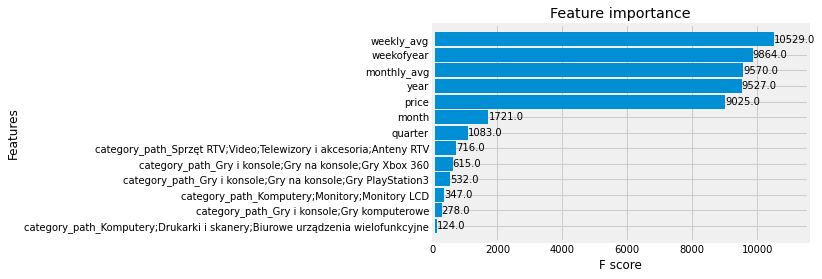

In [24]:
_ = plot_importance(reg, height=0.9)

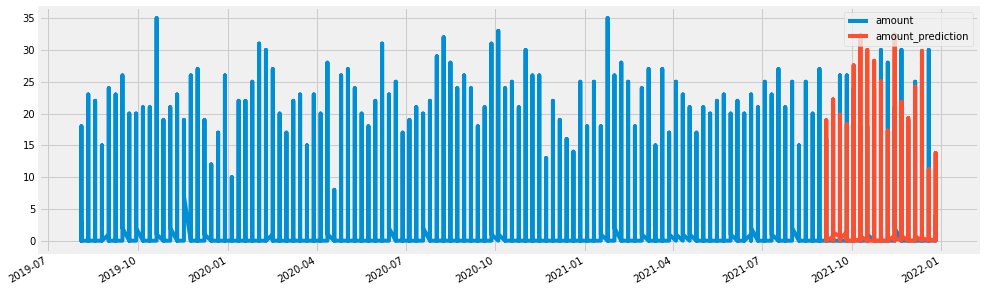

In [26]:
test['amount_prediction'] = reg.predict(X_test)
test['amount_prediction']=test['amount_prediction'].clip(lower=0)
df_all = pd.concat([train, test], sort=False)
_ = df_all[['amount','amount_prediction']].plot(figsize=(15, 5))